# 2. Potential flow with an impenetrable surface

This part introduces the treatment of rigid impenetrable surfaces in `GridPotentialFlow`. We can impose the no-penetration constraint by setting the fluid streamfunction equal to that of the surface $\mathfrak{s}_b$, up to a uniform value $s_0$. The discrete no-penetration constraint is thus

$\mathsf{Es}=\mathfrak{s}_{b}-\mathsf{E} \mathsf{s}_{\infty}-\mathfrak{s}_{0},$

where $\mathsf{E}$ is the interpolation operator that interpolates grid data to the surface points, \mathsf{s}_{\infty} is the streamfunction of the uniform flow. For a body translating at velocity $(U,V)$ and rotating at angular velocity $\Omega$, this streamfunction would be

$\mathfrak{s}_{b,k} = U \mathfrak{r}_y - V \mathfrak{r}_x - \frac{1}{2} \Omega (\mathfrak{r}_x^2+\mathfrak{r}_y^2).$

For later shorthand, we will denote the difference between the body motion streamfunction and interpolated uniform flow streamfunction by $\mathfrak{s}'_b \equiv \mathfrak{s}_b - \mathsf{E} \mathsf{s}_{\infty}$. The no-penetration constraint is enforced in the basic potential flow problem with the help of a vector of Lagrange multipliers, $\mathfrak{f}$, on the surface points. The modified potential flow problem is thus

$\mathsf{Ls} + \mathsf{R}\mathfrak{f} = -\mathsf{w},$

where $\mathsf{R}$ is the regularization operator that transfers data from surface data to nodes. that $\mathsf{E}$ can be constructed (and we will assume it has) so that it is the transpose of the interpolation operator, $\mathsf{E} = \mathsf{R}^{T}$.

From the previous equation, it is clear (by simple comparison with the vorticity on the right-hand side) that the vector $\mathfrak{f}$ represents the strength of the discrete bound vortex sheet on the surface. Suppose we consider the bound vortex sheet $\gamma(s)$ that emerges from the analogous continuous problem on the undiscretized surface, where $s$ is the arc-length parameter along the surface. At each point $p$, the discrete solution $\mathfrak{f}$ is approximately equal to this continuous solution, multiplied by the length $\delta S_p$ of the small segment surrounding the point:

$\mathfrak{e}_{p}^{T} \mathfrak{f} \approx \gamma(s) \delta S_p.$

Thus, the potential flow problem in the presence of the impenetrable surface is

$\begin{bmatrix}
\mathsf{L} & \mathsf{R} \\
\mathsf{E} &  0
\end{bmatrix} \begin{pmatrix} \mathsf{s} \\ \mathfrak{f} \end{pmatrix} =
\begin{pmatrix} -\mathsf{w} \\ \mathfrak{s}'_b - \mathfrak{s}_0 \end{pmatrix}.$

This problem has the structure of a generic saddle-point problem and we will encounter many such systems in this work. `GridPotentialFlow.jl` will automatically formulate the no-penetration constraint on the streamfunction and solve the saddle system when it needs to. See the next page for the role of $\mathfrak{s}_0$ and how it will be treated internally.

We will now consider two examples. In these examples, we use the following grid.

In [1]:
using GridPotentialFlow
using Plots
Δx = 0.01
Lx = 4.0
xlim = (-Lx/2,Lx/2)
ylim = (-Lx/2,Lx/2)
g = PhysicalGrid(xlim,ylim,Δx);

┌ Info: Precompiling GridPotentialFlow [1f0d46c9-1630-4f7c-9a63-ed825740f08c]
└ @ Base loading.jl:1317


In [2]:
using UnPack

## Vortex near a cylinder

As an basic example, consider now a point vortex near a circular cylinder.

`GridPotentialFlow.jl` works with bodies from `RigidBodyTools.jl`. For our circular cylinder, we use the `Circle` constructor.

In [3]:
RadC = Lx/4
Δs = 1.4*cellsize(g);
body = PotentialFlowBody(Circle(RadC,Δs));

We choose an initial position $R_v$ of the vortex at $3/2 R_c$ from the origin.

In [4]:
Rv = 3/2*RadC
Γv = 1.0
v = Vortex(Rv,0.0,Γv);

In [5]:
setΓ(body,-Γv)

-1.0

We construct the `VortexModel` by using the optional `bodies` keyword. In this case, we are interested in the bound vortex sheet strength $\mathfrak{f}$, instead of just the streamfunction field. For this reason, we use `solvesystem`, which in this case returns an `UnregularizedPotentialFlowSolution`.

In [6]:
model = VortexModel(g,vortices=[v],bodies=[body]);
sol = solve(model);

Analytical solution (vortex at Rv and image vortex at Rc^2/Rv)

In [7]:
x, y = body.points.x, body.points.y
r1 = sqrt.((x.-Rv).^2 .+ y.^2) # distance from vortex to points on circle
r2 = sqrt.((x.-RadC^2/Rv).^2 .+ y.^2) # distance from image vortex to points on circle
θ1 = π.+atan.(y./(x.-Rv)) # angle from vortex to points on circle
θ2 = atan.(y,(x.-RadC^2/Rv)) # angle from image vortex to points on circle
v1x = -v.Γ./(2π*r1).*cos.(θ1.-π/2) # x velocity on circle induced by vortex
v1y = -v.Γ./(2π*r1).*sin.(θ1.-π/2) # y velocity on circle induced by vortex
v2x = v.Γ./(2π*r2).*cos.(θ2.-π/2) # x velocity on circle induced by image vortex
v2y = v.Γ./(2π*r2).*sin.(θ2.-π/2) # y velocity on circle induced by image vortex
V = sqrt.((v1x.+v2x).^2+(v1y.+v2y).^2) # velocity magnitude on circle
γ = -V; # bound vortex sheet strength on circle (velocity on circle is clockwise if positive vortex is to the right of it)

### Find the analytical pressure distribution on the surface

In [8]:
zc = x + im*y;
zv = complex(Rv)

1.5 + 0.0im

In [9]:
Fc(z) = Γv/(2π*im)*log(z - zv) - Γv/(2π*im)*log(z - RadC^2/conj(zv))
wcv(z) = Γv/(2π*im)/(z-zv)
wci(z) = -Γv/(2π*im)/(z-RadC^2/conj(zv))
wc(z) = wcv(z) + wci(z)
wv = wci(zv)
dFdzv(z) = -Γv/(2π*im)/(z-zv)
dFdzvstar(z) = -Γv/(2π*im)/(z-RadC^2/conj(zv))*(RadC^2/conj(zv)^2)
Ḟ(z) = dFdzv(z)*conj(wv) + dFdzvstar(z)*wv
press(z) = -real(Ḟ(z)) - 0.5*abs2(wc(z));

In [10]:
dz = 0.5*circshift(zc,-1) - 0.5*circshift(zc,1)
force_pressure = sum(im*press.(zc).*dz)

0.10609981701432188 - 3.74049749507499e-18im

In [11]:
force_imp = im*Γv*(conj(wv)+RadC^2/conj(zv)^2*wv)

0.10610329539459691 + 0.0im

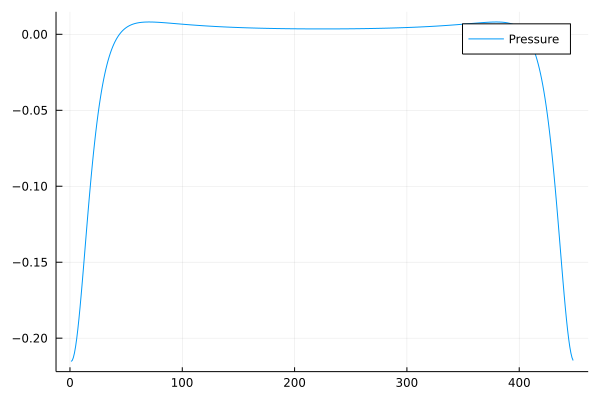

In [12]:
plot(press.(zc),label="Pressure")
#plot!(-real(Ḟ.(zc)))
#plot!(-0.5*abs2.(wc.(zc)))

We can then easily retrieve the streamfunction and the bound vortex sheet strength from the fields of the solution variable.

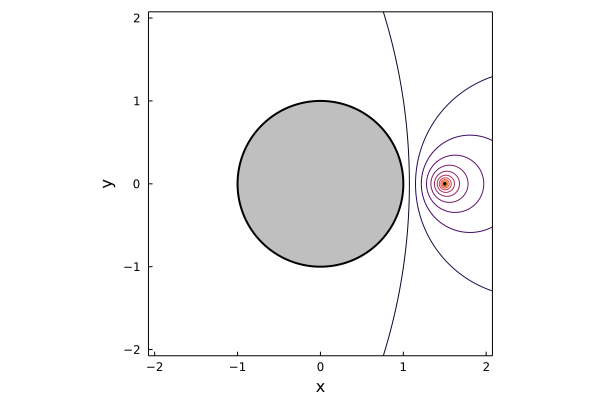

In [13]:
plot(sol.ψ,g)
plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black,linewidth=2)
scatter!([v.x],[v.y],color=:black,markersize=2,xlabel="x",ylabel="y")

For this example, we can easily calculate the analytical bound vortex sheet strength $\gamma$ and compare it with our numerical solution $f$.

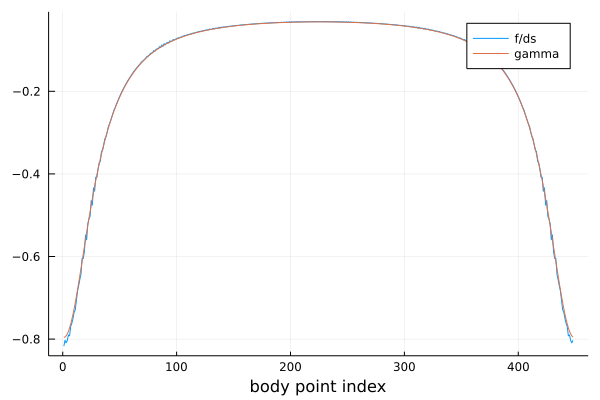

In [14]:
plot(sol.f./Δs,label="f/ds",xlabel="body point index")
plot!(γ,label="gamma")

### Routines to support calculation of jump in normal component surface traction
We need a matrix
$$A = n \cdot I_F C \Delta^{-1} C^T R_F n \circ$$
where $n\circ$ denotes a Hadamard product.

In [16]:
#cache = SurfaceScalarCache(body.points,g,weights=areas(body).data);

In [17]:
#cellsize(cache)

0.01

In [31]:
#=
@unpack bodies = model
@unpack ψ = sol
X = VectorData(collect(bodies))
σtmp = ScalarData(X)  
svtmp = VectorData(X)
    
qtmp = Edges(Primal,ψ)
wtmp = Nodes(Dual,ψ)
ptmp = Nodes(Primal,ψ)

nrm = normals(bodies)

#regop = Regularize(VectorData(collect(bodies)), cellsize(g), I0=origin(g), ddftype = CartesianGrids.Yang3, issymmetric=true)
regop = Regularize(VectorData(collect(bodies)), cellsize(g), I0=origin(g), ddftype = CartesianGrids.Yang3, weights=areas(bodies))
Rf = RegularizationMatrix(regop, svtmp, qtmp)
Ef = InterpolationMatrix(regop, qtmp, svtmp)

Rn = RegularizationMatrix(regop, σtmp, wtmp)
En = InterpolationMatrix(regop, wtmp, σtmp)

L = plan_laplacian(size(wtmp),with_inverse=true);
=#

In [15]:
struct GridPotentialILMProblem{DT,ST} <: AbstractScalarILMProblem{DT,ST}
   g :: PhysicalGrid
   bodies :: BodyList
   GridPotentialILMProblem(g::PT,bodies::BodyList;ddftype=CartesianGrids.Yang3,scaling=IndexScaling) where {PT} = new{ddftype,scaling}(g,bodies)
   GridPotentialILMProblem(g::PT,body::Body;ddftype=CartesianGrids.Yang3,scaling=IndexScaling) where {PT} = new{ddftype,scaling}(g,BodyList([body]))
end

GridPotentialILMProblem(g,body::PotentialFlowBody;kwargs...) = GridPotentialILMProblem(g,body.points;kwargs...)
function GridPotentialILMProblem(g,bodies::Vector{<:PotentialFlowBody};kwargs...)
    bl = BodyList()
    for b in bodies
        push!(bl,b.points)
    end
    GridPotentialILMProblem(g,bl;kwargs...)
end


struct GridPotentialExtraCache{CT,RNT,ENT,RCT,ECT,VT,CVT} <: AbstractExtraILMCache
   CLinvCT :: CT
   Rn :: RNT
   En :: ENT
   Rc :: RCT
   Ec :: ECT
   v_cache :: VT  
   cv_cache :: CVT
end

function ImmersedLayers.prob_cache(prob::GridPotentialILMProblem,base_cache::BasicILMCache)
    @unpack g, regop,gcurl_cache,gdata_cache,sdata_cache  = base_cache
    A = ImmersedLayers.create_CLinvCT(base_cache,scale=cellsize(g))
    Rn = RegularizationMatrix(regop,sdata_cache,gcurl_cache)
    En = InterpolationMatrix(regop,gcurl_cache,sdata_cache)
    Rc = RegularizationMatrix(regop,sdata_cache,gdata_cache)
    Ec = InterpolationMatrix(regop,gdata_cache,sdata_cache)
    v_cache = Edges(Primal,size(g))
    cv_cache = ConvectiveDerivativeCache(EdgeGradient(Primal,size(g)))
    #vt1_cache = EdgeGradient(Primal,size(g))
    #vt2_cache = EdgeGradient(Primal,size(g))
    #vt3_cache = EdgeGradient(Primal,size(g))

    GridPotentialExtraCache(A,Rn,En,Rc,Ec,v_cache,cv_cache)
end

In [16]:
function pressurejump!(dp::ScalarData{N},γn::ScalarData{N},γnp1::ScalarData{N},v̄s::VectorData{N},Δt::Real,sys::ImmersedLayers.ILMSystem{<:GridPotentialILMProblem}) where {N}
    @unpack base_cache, extra_cache = sys
    @unpack g, nrm, gcurl_cache, sdata_cache = base_cache
    @unpack CLinvCT, Rn = extra_cache
    γgrid = Rn*γn
    gcurl_cache .= cellsize(g)*(Rn*γnp1 - γgrid)/Δt
    inverse_laplacian!(gcurl_cache,sys)
    surface_curl!(sdata_cache,gcurl_cache,sys)
    dp .= CLinvCT\sdata_cache
    dp .*= -1.0
    
    cross!(sdata_cache,nrm,v̄s)
    dp .-= sdata_cache∘γn
    
end

function velocity!(v̄::Edges{Primal,NX,NY},ψ::Nodes{Dual,NX,NY},sys::ImmersedLayers.ILMSystem) where {NX,NY}
    @unpack base_cache = sys
    @unpack g = base_cache
    curl!(v̄,ψ)
    v̄ ./= cellsize(g)
end

function surface_velocity!(v̄s::VectorData,v̄::Edges{Primal},sys::ImmersedLayers.ILMSystem)
    @unpack base_cache = sys
    @unpack E = base_cache
    v̄s .= E*v̄
end

surface_velocity! (generic function with 1 method)

In [133]:
#=
vdv = Edges(Primal,size(g))
conv_cache = ConvectiveDerivativeCache(EdgeGradient(Primal,size(g)))
convective_derivative!(vdv,v̄,sys.base_cache,conv_cache)
=#

In [127]:
function pressure!(p̄::Nodes{Primal,NX,NY},v̄::Edges{Primal,NX,NY},dp::ScalarData,sys::ImmersedLayers.ILMSystem) where {NX,NY}
    @unpack base_cache, extra_cache = sys
    @unpack g, L, R, nrm, gsnorm_cache, snorm_cache = base_cache
    @unpack v_cache, cv_cache = extra_cache

    fill!(v_cache,0.0)
    ImmersedLayers.convective_derivative!(v_cache,v̄,base_cache,cv_cache)
    product!(snorm_cache,nrm,dp)
    gsnorm_cache .= R*snorm_cache
    v_cache .-= gsnorm_cache
    
    fill!(p̄,0.0)
    divergence!(p̄,v_cache)
    p̄ ./= cellsize(g)
    inverse_laplacian!(p̄,sys)
    p̄ .*= -1.0
end

pressure! (generic function with 1 method)

In [18]:
prob = GridPotentialILMProblem(g,body,scaling=GridScaling)

GridPotentialILMProblem{CartesianGrids.Yang3, GridScaling}(PhysicalGrid{2}((416, 416), (208, 208), 0.01, ((-2.07, 2.07), (-2.07, 2.07))), BodyList(Body[Circular body with 448 points and radius 1.0
   Current position: (0.0,0.0)
   Current angle (rad): 0.0
]))

In [19]:
sys = ImmersedLayers.__init(prob);

In [18]:
#A = CLinvCT(cache,scale=cellsize(g));
#A = GLinvD(cache,scale=cellsize(g));

In [19]:
using LinearAlgebra

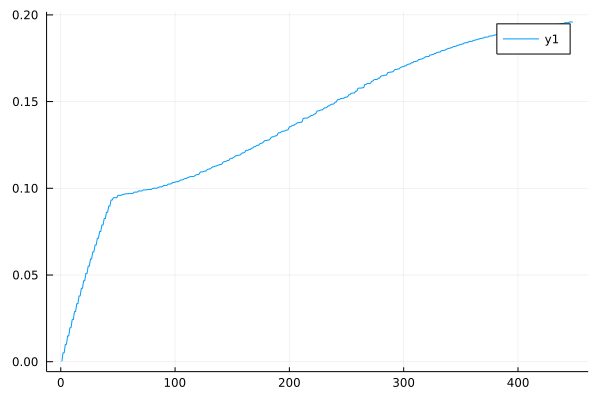

In [25]:
@unpack extra_cache = sys
@unpack CLinvCT = extra_cache
plot(eigvals(CLinvCT))

In [20]:
angs(n) = range(0,2π,length=n+1)[1:n];

#### Move the vortices by one step

In [21]:
vortex = Vortex(Rv,0.0,1.0);
model = VortexModel(g,vortices=[v],bodies=[body]);
sol = solve(model);
X = VectorData(collect(model.bodies));
Xv = getvortexpositions(model);

Δt = 0.01
fn = ScalarData(X);
fnm1 = ScalarData(X);
fnp1 = ScalarData(X);
Ẋn = similar(Xv)
Ẋnp1 = similar(Xv);

In [22]:
Ẋ = vortexvelocities!(model)
soln = solve(model);
Ẋn .= Ẋ
fn .= sol.f
Xv = getvortexpositions(model)
Xv = Xv + Ẋn*Δt
setvortexpositions!(model,Xv)
Xv = getvortexpositions(model)
Ẋ = vortexvelocities!(model);
solnp1 = solve(model);
Ẋnp1 .= Ẋ
fnp1 .= solnp1.f;

### Plot the surface velocities

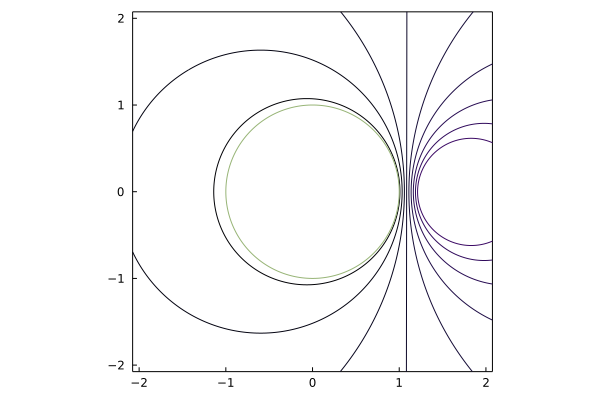

In [23]:
plot(solnp1.ψ,g,levels=range(-0.5,0.1,length=31))
plot!(body,fillalpha=0)

In [24]:
v̄ = similar(sys.base_cache.gsnorm_cache)
v̄s = similar(sys.base_cache.snorm_cache)
velocity!(v̄,sol.ψ,sys)
surface_velocity!(v̄s,v̄,sys);

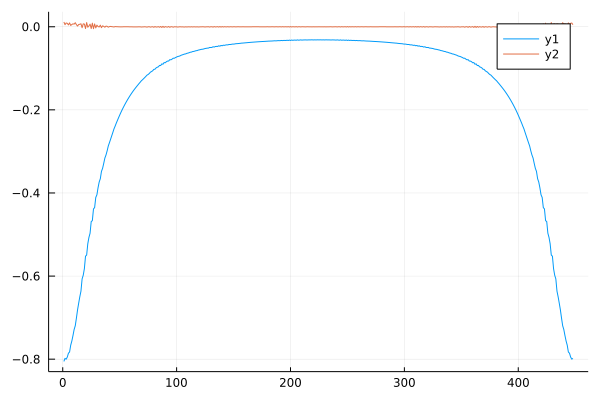

In [25]:
@unpack base_cache, extra_cache = sys
@unpack g, nrm, gcurl_cache, sdata_cache = base_cache

cross!(sdata_cache,nrm,v̄s)
plot(sdata_cache .+ 0.5*fn./Δs)
plot!(sdata_cache .- 0.5*fn./Δs)

In [26]:
dp = ScalarData(X)
pressurejump!(dp,fn./Δs,fnp1./Δs,v̄s,Δt,sys);

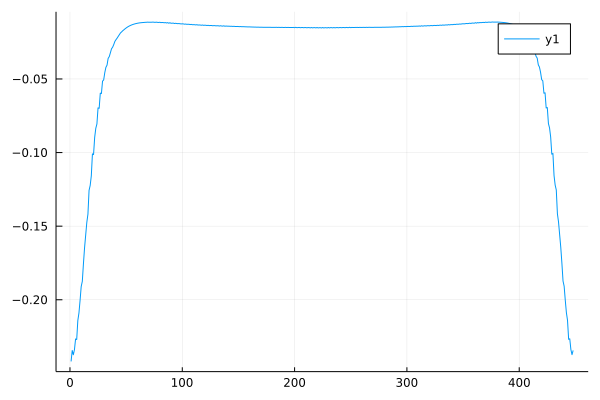

In [27]:
plot(dp)

In [128]:
p̄ = Nodes(Primal,sol.ψ)
pressure!(p̄,v̄,dp,sys);

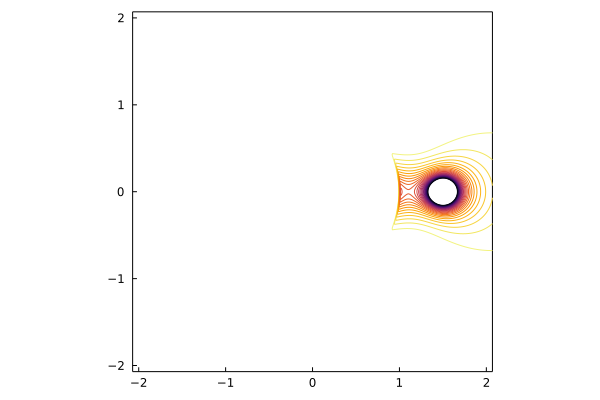

In [130]:
plot(p̄,g,clim=(-0.5,0),levels=range(-0.5,0,length=31))

In [131]:
p̄s = ScalarData(sol.f)
#Rc, Ec = _mycomputeregularizationmatrix(g,X,p̄s,p̄);
#Ec = InterpolationMatrix(sys.base_cache.regop,p̄,p̄s)
p̄s .= sys.extra_cache.Ec*p̄ + 0.5*dp;

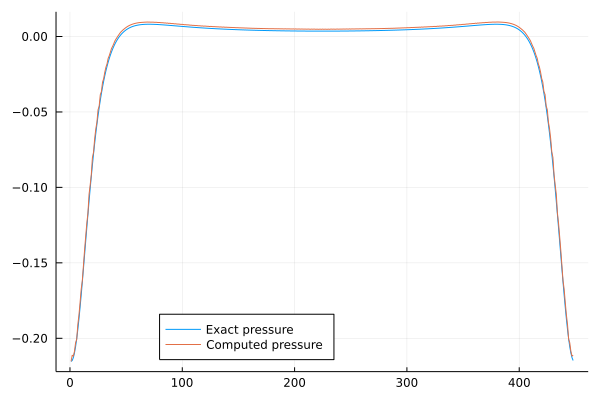

In [132]:
plot(press.(zc),label="Exact pressure",legend=:bottom)
plot!(p̄s,label="Computed pressure")

In [34]:
#v̄s = cache.E*v̄;

LoadError: UndefVarError: v̄ not defined

In [953]:
#v̄sn = ScalarData(X)
#cross!(v̄sn,nrm,v̄s);

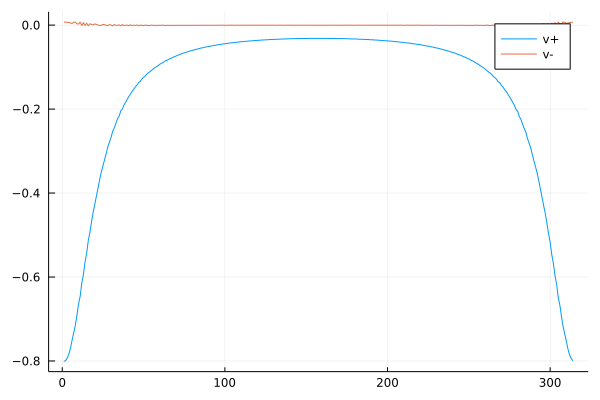

In [954]:
#plot(v̄sn + 0.5*f./Δs,label="v+")
#plot!(v̄sn - 0.5*f./Δs,label="v-")

#### Functions

Redefine `_computeregularizationmatrix` to allow weights

In [15]:
function _mycomputeregularizationmatrix(g::PhysicalGrid, X::VectorData{N}, f::VectorData{N}, s::VectorGridData; ddftype=CartesianGrids.Yang3, weights=nothing) where {N}

    if isnothing(weights)
        regop = Regularize(X, cellsize(g), I0=origin(g), ddftype = ddftype, issymmetric=true )
        Rmat, _ = RegularizationMatrix(regop, f, s)
        Emat = InterpolationMatrix(regop, s, f)
    else
        regop = Regularize(X, cellsize(g), I0=origin(g), ddftype = ddftype, weights=weights)
        Rmat = RegularizationMatrix(regop, f, s)
        Emat = InterpolationMatrix(regop, s, f)
    end



    return Rmat, Emat
end


_mycomputeregularizationmatrix (generic function with 1 method)

In [16]:

function _mycomputeregularizationmatrix(g::PhysicalGrid, X::VectorData{N}, f::ScalarData{N}, s::Nodes; ddftype=CartesianGrids.Yang3, weights=nothing) where {N}

    if isnothing(weights)
        regop = Regularize(X, cellsize(g), I0=origin(g), ddftype = ddftype, issymmetric=true )
        Rmat, _ = RegularizationMatrix(regop, f, s)
        Emat = InterpolationMatrix(regop, s, f)
    else
        regop = Regularize(X, cellsize(g), I0=origin(g), ddftype = ddftype, weights=weights)
        Rmat = RegularizationMatrix(regop, f, s)
        Emat = InterpolationMatrix(regop, s, f)
    end 

    return Rmat, Emat
end


_mycomputeregularizationmatrix (generic function with 2 methods)

In [17]:
function surface_matrix(ψ::Nodes{Dual},g::PhysicalGrid,b::Body) #,Rf,Ef)
    X = VectorData(collect(b))
    
    σtmp = ScalarData(X)  
    stmp = VectorData(X)
    
    qtmp = Edges(Primal,ψ)
    wtmp = Nodes(Dual,ψ)

    areas = ScalarData(dlengthmid(b))
    nrm = VectorData(normalmid(b)...)
    
    N = length(σtmp)

    Rf, Ef = _mycomputeregularizationmatrix(g,X,X,qtmp,weights=areas.data)
    L = plan_laplacian(size(wtmp),with_inverse=true);
    
    A = Matrix{Float64}(undef,N,N);

    for col in 1:N
        σtmp[col] = 1.0
        qtmp .= Rf*(nrm∘σtmp)
        fill!(wtmp,0.0)
        curl!(wtmp,qtmp)
        #wtmp ./= cellsize(g)
        wtmp .= -(L\wtmp);
        fill!(qtmp,0.0)
        curl!(qtmp,wtmp)
        #qtmp ./= cellsize(g)
        stmp .= Ef*qtmp
        A[:,col] = cellsize(g)*pointwise_dot(nrm,stmp)
        σtmp[col] = 0.0
    end
    
    #=
    A = Matrix{Float64}(undef,2N,2N);
    σvtmp = VectorData(X)
    
    fill!(σvtmp,0.0)
    for col in 1:2N
        σvtmp[col] = 1.0
        qtmp .= Rf*σvtmp
        fill!(wtmp,0.0)
        curl!(wtmp,qtmp)
        wtmp .= -(L\wtmp);
        #wtmp ./= cellsize(g)
        fill!(qtmp,0.0)
        curl!(qtmp,wtmp)
        #qtmp ./= cellsize(g)
        stmp .= Ef*qtmp
        A[:,col] = stmp
        σvtmp[col] = 0.0
    end
    =#
    
    return A

end

surface_matrix (generic function with 1 method)

In [18]:
function traction(γ::ScalarData{N},γnp1::ScalarData{N},ψ::Nodes{Dual},A::Matrix,g::PhysicalGrid,b::Body,Δt::Real) where {N} #,Ef,Rn,En) where {N}
    X = VectorData(collect(b))
    σtmp = ScalarData(X)
    stmp = VectorData(X)
    rhs = ScalarData(X)
    
    qtmp = Edges(Primal,ψ)
    wtmp = Nodes(Dual,ψ)
    qdtmp1 = Edges(Dual,ψ)
    qdtmp2 = Edges(Dual,ψ)
    qdtmp3 = Edges(Dual,ψ)
    v̄ = Edges(Primal,ψ)
    
    areas = ScalarData(dlengthmid(b))
    nrm = VectorData(normalmid(b)...)
    
    Rf, Ef = _mycomputeregularizationmatrix(g,X,X,qtmp,weights=areas.data)
    Rn, En = _mycomputeregularizationmatrix(g,X,σtmp,wtmp,weights=areas.data)
    
    #=
    A = Matrix{Float64}(undef,N,N);

    for col in 1:N
        σtmp[col] = 1.0
        qtmp .= Rf*(nrm∘σtmp)
        fill!(wtmp,0.0)
        curl!(wtmp,qtmp)
        fill!(qtmp,0.0)
        curl!(qtmp,wtmp)
        stmp .= Ef*qtmp
        A[:,col] = pointwise_dot(nrm,stmp)
        σtmp[col] = 0.0
    end
    =#
    
    curl!(v̄,ψ)
    v̄ ./= cellsize(g)
    w̄ = Nodes(Dual,ψ)
    curl!(w̄,v̄)
    
    γgrid = Rn*γ
    fill!(wtmp,0.0)
    fill!(qtmp,0.0)
    
    L = plan_laplacian(size(wtmp),with_inverse=true);

    
    
    #divergence!(wtmp,product!(qdtmp3,grid_interpolate!(qdtmp1,v̄),grid_interpolate!(qdtmp2,γgrid)))
    wtmp .+= cellsize(g)*(Rn*γnp1 - γgrid)/Δt # this should be +, not -
    #wtmp .+= (Rn*γnp1 - γgrid)/Δt # this should be +, not -
    wtmp .= -cellsize(g)*(L\wtmp);
    
    

    #=
    vdv = Edges(Primal,ψ)
    _unscaled_convective_derivative!(vdv,v̄)
    #vdv ./= cellsize(g)
    curl!(wtmp,-vdv)
    #curl!(wtmp,v̄/Δt)
    wtmp .= (L\wtmp);
    =#
    
    curl!(qtmp,wtmp)
    #qtmp ./= cellsize(g)
    
    stmp .= Ef*qtmp
    rhs .= -pointwise_dot(nrm,stmp)
    
    σ = ScalarData(X)
    σ .= A\rhs.data
        
end

traction (generic function with 1 method)

In [34]:
v̄ = Edges(Primal,size(g))
w = Nodes(Dual,size(g))
σ = ScalarData(X)
nrm = normals(body)
Rf, Ef = _mycomputeregularizationmatrix(g,X,X,v̄,weights=areas(body).data)
Rn, En = _mycomputeregularizationmatrix(g,X,σ,w,weights=areas(body).data)
#Rn, En = _mycomputeregularizationmatrix(g,X,σ,w,weights=areas.data)
#Rn, En = _mycomputeregularizationmatrix(g,X,σ,w)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [27]:
#=
A = CLinvCT(cache,scale=cellsize(g));
=#

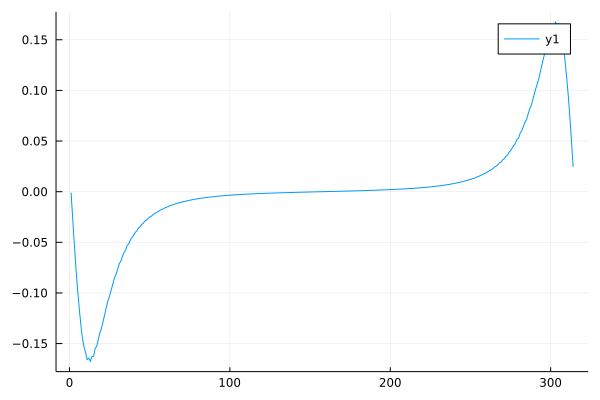

In [964]:
plot((fn-fnp1)./Δs/Δt)

In [24]:
#=
A = surface_matrix(sol.ψ,g,body.points); #,sys.base_cache.R,sys.base_cache.E);
=#

In [35]:
#=
σ1 = traction(fn./Δs,fnp1./Δs,sol.ψ,A,g,body.points,Δt);


v̄ = Edges(Primal,sol.ψ)
curl!(v̄,sol.ψ)
v̄ ./= cellsize(g)
v̄s = Ef*v̄;
v̄ns = ScalarData(X)
cross!(v̄ns,nrm,v̄s);
σ = σ1 + (v̄ns∘fn./Δs);

#σ = σ1;
=#

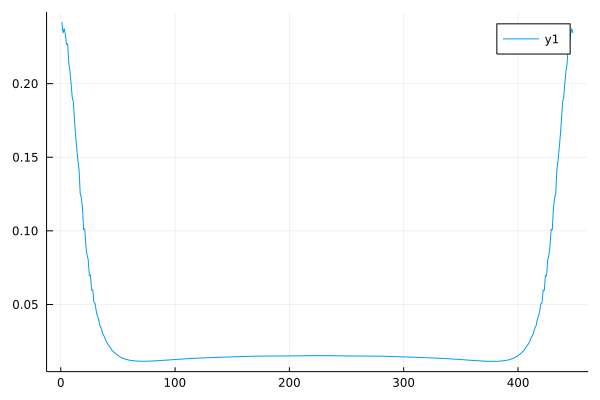

In [36]:
plot(σ)

In [31]:
#=
b = body.points
#v̄ = Edges(Primal,sol.ψ)
#curl!(v̄,sol.ψ)
#v̄ ./= cellsize(g);
vdv = Edges(Primal,sol.ψ)
prhs = Nodes(Primal,sol.ψ)
ptmp = Nodes(Primal,sol.ψ)

nrm = VectorData(normalmid(b)...)
#ar = ScalarData(dlengthmid(b))
#Rf, Ef = _mycomputeregularizationmatrix(g,X,X,v̄,weights=areas.data)
Rf = sys.base_cache.R
Ef = sys.base_cache.E

divergence!(prhs,_unscaled_convective_derivative!(vdv,v̄)-cellsize(g)*(Rf*(nrm∘dp)));
#divergence!(prhs,_unscaled_convective_derivative!(vdv,v̄)+Rf*(nrm∘σ));
=#

In [32]:
#p̄ = Nodes(Primal,sol.ψ)
#L = plan_laplacian(size(p̄),with_inverse=true);
#p̄ .= -(sys.base_cache.L\prhs);


### Moving point vortex outside cylinder

In [111]:
Rv = 3/2*Rc
vortex = Vortex(Rv,0.0,1.0);

We construct the `VortexModel` by using the optional `bodies` keyword. In this case, we are interested in the bound vortex sheet strength $\mathfrak{f}$, instead of just the streamfunction field. For this reason, we use `solvesystem`, which in this case returns an `UnregularizedPotentialFlowSolution`.

In [137]:
model = VortexModel(g,vortices=[vortex],bodies=[circle]);
w = computew(model)
sol = solvesystem(model,w);

In [144]:
Δt = 0.02
T = 0:Δt:0.1
for t in T
    Ẋ, f = computevortexvelocities_plus(model)
    X = getvortexpositions(model)
    X = X + Ẋ*Δt
    setvortexpositions!(model,X)
end

[-0.050077161313666754, -0.047749498356823614, -0.04390612969202968, -0.038838563190918024, -0.03361178268933732, -0.029253561075604045, -0.02509114961764067, -0.02141860917712807, -0.018417372882729953, -0.016156824567795155, -0.014194383571573752, -0.012222029178775995, -0.011134536751217273, -0.009576878277319784, -0.008905025451083138, -0.007764166693090032, -0.007210634454804725, -0.00651869386135369, -0.005912119747148748, -0.0054736294804875575, -0.0050967904205077574, -0.004729226996914763, -0.004367053312066925, -0.0041138027970850435, -0.0038710728562809447, -0.0036274493551113215, -0.0034279633443388994, -0.003253752377167533, -0.003112050770770167, -0.0029609503799106905, -0.0028148976293735943, -0.002725951628321048, -0.0026201400816912037, -0.0025072295264454785, -0.002410625153925079, -0.0023585433071499043, -0.002304453795466587, -0.002192435336236145, -0.0022029540176976416, -0.0020755904381440033, -0.0021049606954209716, -0.001998980715843459, -0.0020077505094257373, 

[-0.04982152786331438, -0.047144291970368436, -0.043091046988816, -0.0379641195918182, -0.032780177486417886, -0.028502287584112922, -0.0244451152594609, -0.020878017254125303, -0.01796782211003475, -0.015778869183443088, -0.013878122783842555, -0.011963335385139528, -0.010911431307517806, -0.009395204025248785, -0.008745162860776715, -0.007632541434469577, -0.007094905593989498, -0.006419813732143908, -0.005827271984118181, -0.005399267308662256, -0.0050312709922905, -0.004671716903792176, -0.004316789816730569, -0.004068982811301046, -0.0038311825133866126, -0.0035920962856211035, -0.003396371747296072, -0.00322541525184693, -0.003086464721383127, -0.0029379964316476, -0.002794334325033418, -0.0027072140072457295, -0.0026032333491532176, -0.002492063644610045, -0.0023969784832092583, -0.002346084892282178, -0.0022931410859250777, -0.0021824520628502203, -0.002193712533326221, -0.0020675918112082006, -0.0020975526257472313, -0.0019926209331194915, -0.0020020056360628767, -0.0019558828

In [135]:
X = getvortexpositions(model)

1 points of vector-valued Float64 data
2-element Vector{Float64}:
  0.41425924545672055
 -1.4444046491335318

In [140]:
model.system.f

LoadError: type UnregularizedPotentialFlowSystem has no field f

## Moving cylinder

In this example we will create a model with a moving body.

Here we use the keyword `parameters` to solve our model with a `ModelParameters` variable, in which we enter a velocity for our body using the `Ub` keyword.

In [9]:
model = VortexModel(g,bodies=[circle]);
w = computew(model)
modelparameters = ModelParameters(Ub=[(1.0,0.0)])
sol = solvesystem(model,w,parameters=modelparameters);

# Analytical solution

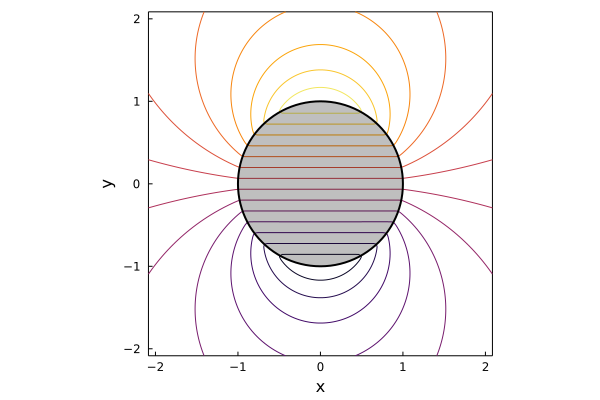

In [10]:
θ = atan.(circle.y,circle.x)
γ = 2*sin.(θ);

plot(sol.ψ,g)
plot!(circle,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black,linewidth=2,xlabel="x",ylabel="y")

Again, we can compare the discrete bound vortex sheet strength with the analytical vortex sheet strength.

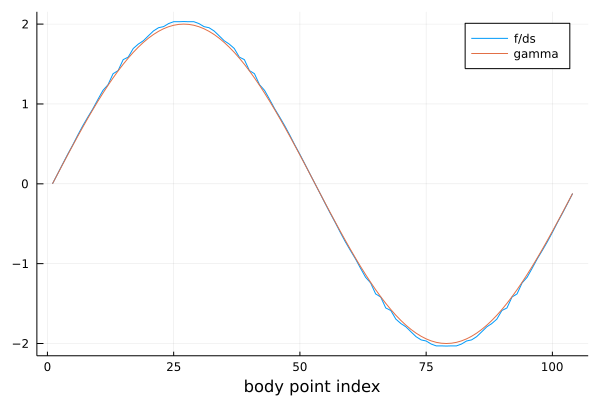

In [11]:
plot(sol.f./Δs,label="f/ds",xlabel="body point index")
plot!(γ,label="gamma")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*